# Data Preparation of titanic dataset

In [26]:
# Load packages
library('ggplot2') # visualization
#library('ggthemes') # visualization
library('scales') # visualization
library('dplyr') # data manipulation
library('mice') # imputation
library(titanic)
data(Titanic)


In [27]:
train <- titanic_train
test  <- titanic_test

full  <- bind_rows(train, test) # bind training & test data

# check data
str(full)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


In [28]:
# Grab title from passenger names
full$Title <- gsub('(.*, )|(\\..*)', '', full$Name)

# Show title counts by sex
table(full$Sex, full$Title)

        
         Capt Col Don Dona  Dr Jonkheer Lady Major Master Miss Mlle Mme  Mr Mrs
  female    0   0   0    1   1        0    1     0      0  260    2   1   0 197
  male      1   4   1    0   7        1    0     2     61    0    0   0 757   0
        
          Ms Rev Sir the Countess
  female   2   0   0            1
  male     0   8   1            0

In [29]:
# Titles with very low cell counts to be combined to "rare" level
rare_title <- c('Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer')

# Also reassign mlle, ms, and mme accordingly
full$Title[full$Title == 'Mlle']        <- 'Miss' 
full$Title[full$Title == 'Ms']          <- 'Miss'
full$Title[full$Title == 'Mme']         <- 'Mrs' 
full$Title[full$Title %in% rare_title]  <- 'Rare Title'

# Show title counts by sex again
table(full$Sex, full$Title)

        
         Master Miss  Mr Mrs Rare Title
  female      0  264   0 198          4
  male       61    0 757   0         25

In [30]:
# Create a family size variable including the passenger themselves
full$Fsize <- full$SibSp + full$Parch + 1

# Create a family variable 
full$Family <- paste(full$Surname, full$Fsize, sep='_')

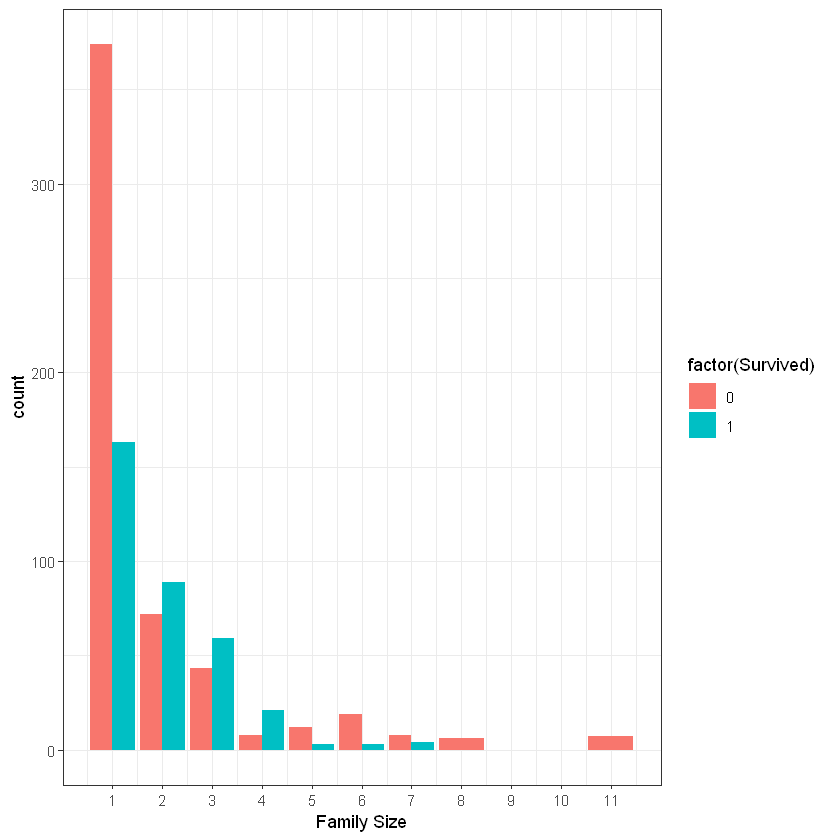

In [31]:
# Use ggplot2 to visualize the relationship between family size & survival
ggplot(full[1:891,], aes(x = Fsize, fill = factor(Survived))) +
  geom_bar(stat='count', position='dodge') +
  scale_x_continuous(breaks=c(1:11)) +
  labs(x = 'Family Size') +
  theme_bw()

In [32]:
# Discretize family size
full$FsizeD[full$Fsize == 1] <- 'singleton'
full$FsizeD[full$Fsize < 5 & full$Fsize > 1] <- 'small'
full$FsizeD[full$Fsize > 4] <- 'large'

In [33]:
# Create a Deck variable. Get passenger deck A - F:
full$Deck<-factor(sapply(full$Cabin, function(x) strsplit(x, NULL)[[1]][1]))

In [34]:
# Passengers 62 and 830 are missing Embarkment
full[c(62, 830), 'Embarked']

[1] "" ""

In [35]:
# Since their fare was $80 for 1st class, they most likely embarked from 'C'
full$Embarked[c(62, 830)] <- 'C'

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."


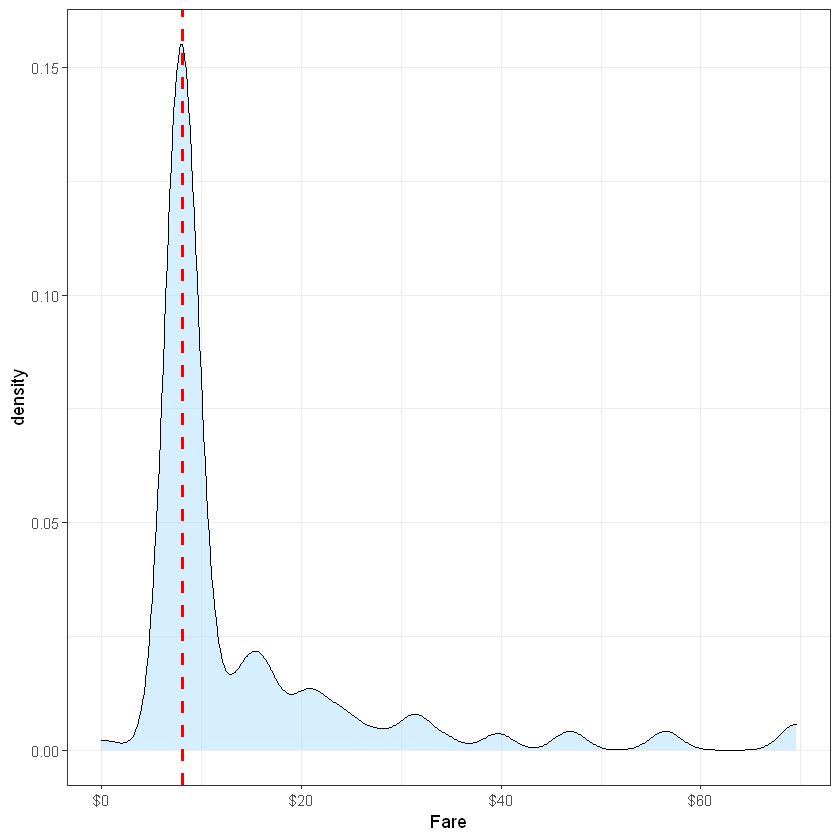

In [36]:
ggplot(full[full$Pclass == '3' & full$Embarked == 'S', ], 
  aes(x = Fare)) +
  geom_density(fill = '#99d6ff', alpha=0.4) + 
  geom_vline(aes(xintercept=median(Fare, na.rm=T)),
    colour='red', linetype='dashed', lwd=1) +
  scale_x_continuous(labels=dollar_format()) +
  theme_bw()

In [37]:
# Replace missing fare value with median fare for class/embarkment
full$Fare[1044] <- median(full[full$Pclass == '3' & full$Embarked == 'S', ]$Fare, na.rm = TRUE)

In [38]:
# Make variables factors into factors
factor_vars <- c('PassengerId','Pclass','Sex','Embarked',
                 'Title','Family','FsizeD')

full[factor_vars] <- lapply(full[factor_vars], function(x) as.factor(x))

# Set a random seed
set.seed(129)

# Perform mice imputation, excluding certain less-than-useful variables:
mice_mod <- mice(full[, !names(full) %in% c('PassengerId','Name','Ticket','Cabin','Family','Survived')], method='rf') 


 iter imp variable
  1   1  Age  Deck
  1   2  Age  Deck
  1   3  Age  Deck
  1   4  Age  Deck
  1   5  Age  Deck
  2   1  Age  Deck
  2   2  Age  Deck
  2   3  Age  Deck
  2   4  Age  Deck
  2   5  Age  Deck
  3   1  Age  Deck
  3   2  Age  Deck
  3   3  Age  Deck
  3   4  Age  Deck
  3   5  Age  Deck
  4   1  Age  Deck
  4   2  Age  Deck
  4   3  Age  Deck
  4   4  Age  Deck
  4   5  Age  Deck
  5   1  Age  Deck
  5   2  Age  Deck
  5   3  Age  Deck
  5   4  Age  Deck
  5   5  Age  Deck


Warning message:
"Number of logged events: 50"


In [39]:
# Save the complete output 
mice_output <- complete(mice_mod)

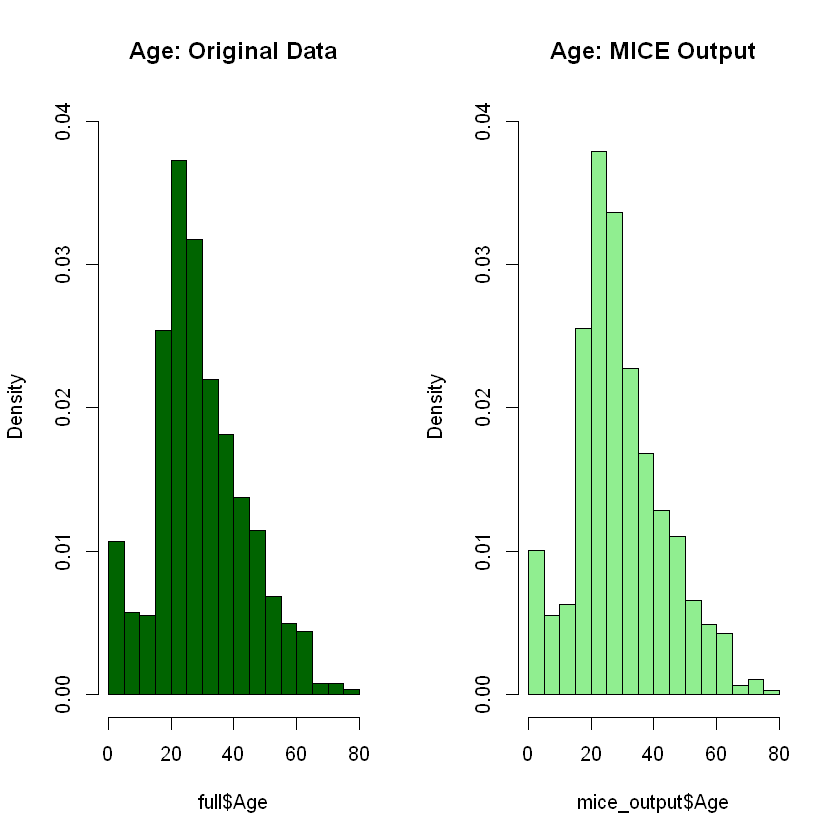

In [40]:
# Plot age distributions
par(mfrow=c(1,2))
hist(full$Age, freq=F, main='Age: Original Data', 
  col='darkgreen', ylim=c(0,0.04))
hist(mice_output$Age, freq=F, main='Age: MICE Output', 
  col='lightgreen', ylim=c(0,0.04))

In [41]:
# Replace Age variable from the mice model.
full$Age <- mice_output$Age

# Show new number of missing Age values
sum(is.na(full$Age))

[1] 0

## Save processed training data for modelling 

In [42]:
# Split the data back into a train set and a test set
train <- full[1:891,]
test <- full[892:1309,]

train1 = train[,c("Survived","Pclass", "Sex", "Age", "SibSp", "Parch", 
                                            "Fare", "Embarked", "Title", 
                                            "FsizeD")]

In [84]:
write.csv(train1,"titanic.csv")